In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np



file_path = '../data/Womens Clothing E-Commerce Reviews.csv'
data = pd.read_csv(file_path)

data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


(None,
    Unnamed: 0  Clothing ID  Age                    Title  \
 0           0          767   33                      NaN   
 1           1         1080   34                      NaN   
 2           2         1077   60  Some major design flaws   
 3           3         1049   50         My favorite buy!   
 4           4          847   47         Flattering shirt   
 
                                          Review Text  Rating  Recommended IND  \
 0  Absolutely wonderful - silky and sexy and comf...       4                1   
 1  Love this dress!  it's sooo pretty.  i happene...       5                1   
 2  I had such high hopes for this dress and reall...       3                0   
 3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
 4  This shirt is very flattering to all due to th...       5                1   
 
    Positive Feedback Count   Division Name Department Name Class Name  
 0                        0       Initmates        Intimat

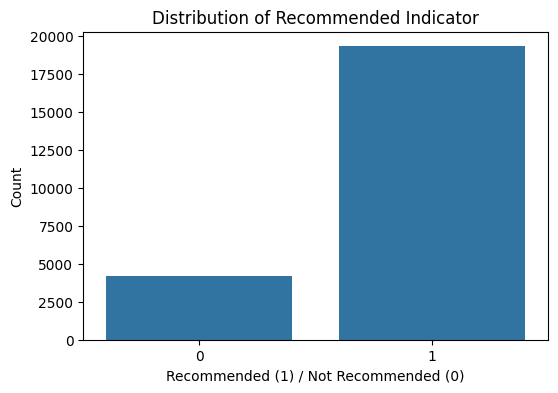

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [ ]:
missing_values = data.isnull().sum()


plt.figure(figsize=(6, 4))
sns.countplot(x='Recommended IND', data=data)
plt.title('Distribution of Recommended Indicator')
plt.xlabel('Recommended (1) / Not Recommended (0)')
plt.ylabel('Count')
plt.show()

missing_values

Title: 3,810 missing values <br>
Review Text: 845 missing values (key for NLP processing) <br>
Division Name, Department Name, and Class Name: 14 missing values each

In [4]:
data = data.drop("Unnamed: 0",axis=1)
data = data.dropna(subset=["Review Text"]).reset_index(drop=True)

In [5]:
data

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
22636,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
22637,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
22638,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
22639,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [6]:
data[data["Clothing ID"].duplicated(keep=False)]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
22636,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
22637,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
22638,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
22639,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Keep only letters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize & remove stop words
    return ' '.join(tokens)


data['Cleaned Review Text'] = data['Review Text'].apply(clean_text)


data[['Review Text', 'Cleaned Review Text']].head()

,Review Text,Cleaned Review Text
0,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store gla...
2,I had such high hopes for this dress and reall...,high hope dress really wanted work initially o...
3,"I love, love, love this jumpsuit. it's fun, fl...",love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,shirt flattering due adjustable front tie perf...


In [ ]:
X = data['Cleaned Review Text']
y = data['Recommended IND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tfidf_vectorizer = TfidfVectorizer(max_features=5000)  


X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


X_train_tfidf.shape, X_test_tfidf.shape

((18112, 5000), (4529, 5000))

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

y_prob = rf_classifier.predict_proba(X_test_tfidf)


y_pred_threshold = (y_prob[:, 1] > 0.7).astype(int)


accuracy_threshold = accuracy_score(y_test, y_pred_threshold)
f1_threshold = f1_score(y_test, y_pred_threshold)
conf_matrix_threshold = confusion_matrix(y_test, y_pred_threshold)
class_report_threshold = classification_report(y_test, y_pred_threshold)


print("Results with 0.7 probability threshold:")
print(f"Accuracy: {accuracy_threshold:.4f}")
print(f"F1 Score: {f1_threshold:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_threshold)
print("\nClassification Report:")
print(class_report_threshold)


y_pred_original = rf_classifier.predict(X_test_tfidf)
print("\nOriginal Results (0.5 threshold):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_original):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_original):.4f}")

Results with 0.7 probability threshold:
Accuracy: 0.8766
F1 Score: 0.9242

Confusion Matrix:
[[ 561  251]
 [ 308 3409]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       812
           1       0.93      0.92      0.92      3717

    accuracy                           0.88      4529
   macro avg       0.79      0.80      0.80      4529
weighted avg       0.88      0.88      0.88      4529


Original Results (0.5 threshold):
Accuracy: 0.8640
F1 Score: 0.9227


In [ ]:
attributes = {
    'size': ['size', 'fit', 'small', 'large', 'tight', 'loose'],
    'quality': ['quality', 'material', 'fabric', 'stitch', 'durable', 'cheap'],
    'comfort': ['comfortable', 'uncomfortable', 'soft', 'wear', 'feel'],
    'style': ['style', 'design', 'fashion', 'look', 'beautiful', 'ugly'],
}


def extract_attributes(review, attributes):
    result = {attr: 0 for attr in attributes}
    for attr, keywords in attributes.items():
        for keyword in keywords:
            if keyword in review:
                result[attr] += 1
    return result


data['Attributes'] = data['Cleaned Review Text'].apply(lambda x: extract_attributes(x, attributes))


attributes_df = data['Attributes'].apply(pd.Series)
data_with_attributes = pd.concat([data, attributes_df], axis=1)


attribute_summary = attributes_df.sum()
print("Summary of Attribute Mentions:")
print(attribute_summary)

Summary of Attribute Mentions:
size       26963
quality     9661
comfort    15396
style      13874
dtype: int64


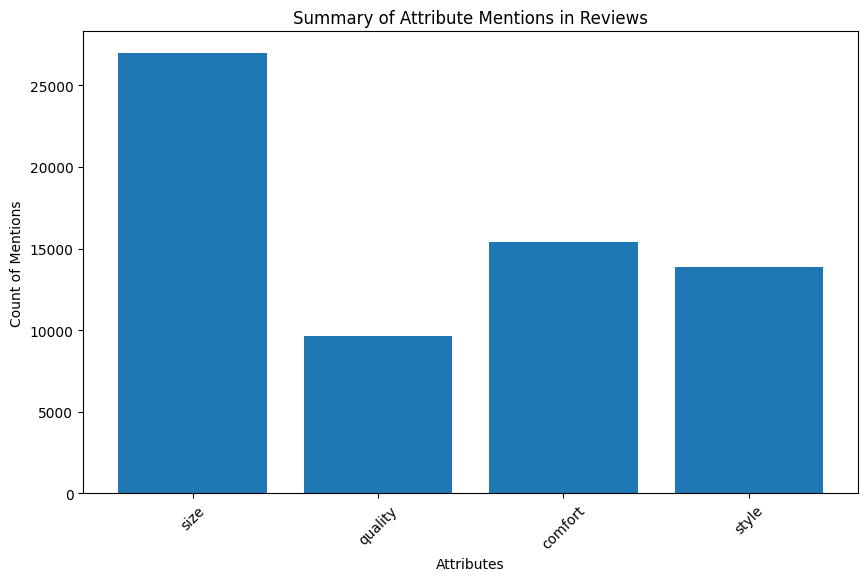

In [ ]:
attribute_summary = attributes_df.sum()

plt.figure(figsize=(10, 6))
plt.bar(attribute_summary.index, attribute_summary.values)
plt.title("Summary of Attribute Mentions in Reviews")
plt.xlabel("Attributes")
plt.ylabel("Count of Mentions")
plt.xticks(rotation=45)
plt.show()

Faktor Size Dominan: <br>
Ukuran merupakan atribut yang paling banyak disebutkan dalam review dengan sekitar 27,000 mentions <br>
Ini menunjukkan bahwa konsumen sangat memperhatikan dan peduli tentang aspek ukuran produk <br>
Mungkin banyak pembeli yang membahas masalah fitting atau kesesuaian ukuran <br>


Comfort & Style Seimbang: <br>
Comfort (kenyamanan) dan style (gaya) memiliki jumlah mentions yang hampir setara, masing-masing sekitar 15,000 mentions <br>
Ini mengindikasikan bahwa konsumen mementingkan keseimbangan antara kenyamanan dan penampilan <br>
Kedua aspek ini menjadi pertimbangan penting setelah ukuran <br>


Quality Mendapat Perhatian Lebih Rendah: <br>
Quality memiliki mentions terendah, sekitar 9,000 <br>

Ini bisa mengindikasikan beberapa hal: <br>
Konsumen mungkin lebih fokus pada aspek yang langsung terlihat/terasa <br>
Kualitas produk mungkin sudah cukup baik sehingga tidak terlalu dibahas <br>
Atau sebaliknya, konsumen kurang memperhatikan aspek kualitas <br>



Rekomendasi untuk Bisnis: <br>

Fokus pada sizing yang tepat dan konsisten karena ini adalah concern utama konsumen <br>
Mempertahankan keseimbangan antara aspek kenyamanan dan gaya <br>
Meskipun kualitas kurang dibahas, tetap penting untuk dijaga <br>
Mungkin perlu edukasi konsumen tentang aspek kualitas produk <br>



Prioritas Konsumen: <br>
Urutan prioritas konsumen berdasarkan mentions: <br>

1. Faktor Ukuran (Size) Dominan:
- Ukuran merupakan atribut yang paling banyak disebutkan dalam review dengan sekitar 27,000 mentions
- Ini menunjukkan bahwa konsumen sangat memperhatikan dan peduli tentang aspek ukuran produk
- Mungkin banyak pembeli yang membahas masalah fitting atau kesesuaian ukuran

1. comfort & style Seimbang:
- Comfort (kenyamanan) dan style (gaya) memiliki jumlah mentions yang hampir setara, masing-masing sekitar 15,000 mentions
- Ini mengindikasikan bahwa konsumen mementingkan keseimbangan antara kenyamanan dan penampilan
- Kedua aspek ini menjadi pertimbangan penting setelah ukuran

1. Quality Mendapat Perhatian Lebih Rendah:
- Quality (kualitas) memiliki mentions terendah, sekitar 9,000
- Ini bisa mengindikasikan beberapa hal:
  * Konsumen mungkin lebih fokus pada aspek yang langsung terlihat/terasa
  * Kualitas produk mungkin sudah cukup baik sehingga tidak terlalu dibahas
  * Atau sebaliknya, konsumen kurang memperhatikan aspek kualitas

1. Rekomendasi untuk Bisnis:
- Fokus pada sizing yang tepat dan konsisten karena ini adalah concern utama konsumen
- Mempertahankan keseimbangan antara aspek kenyamanan dan gaya
- Meskipun kualitas kurang dibahas, tetap penting untuk dijaga
- Mungkin perlu edukasi konsumen tentang aspek kualitas produk

1. Prioritas Konsumen:
- Urutan prioritas konsumen berdasarkan mentions:
  1. Size
  2. Comfort
  3. Style
  4. Quality

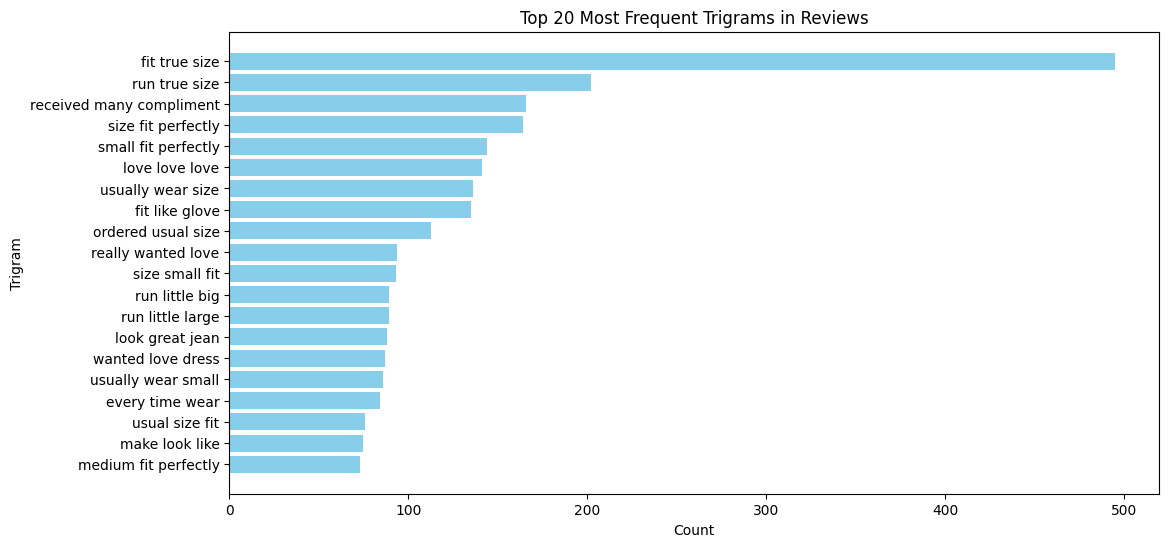

In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=20)  # Extract top 20 trigrams
trigram_matrix = vectorizer.fit_transform(data['Cleaned Review Text'])

trigram_counts = trigram_matrix.sum(axis=0).A1
trigram_features = vectorizer.get_feature_names_out()


trigram_df = pd.DataFrame({'Trigram': trigram_features, 'Count': trigram_counts}).sort_values(by='Count', ascending=False)


plt.figure(figsize=(12, 6))
plt.barh(trigram_df['Trigram'], trigram_df['Count'], color='skyblue')
plt.gca().invert_yaxis()  
plt.title("Top 20 Most Frequent Trigrams in Reviews")
plt.xlabel("Count")
plt.ylabel("Trigram")
plt.show()

Ukuran sangat penting bagi pembeli. Trigram terkait ukuran seperti "fit true size", "run true size", "size fit perfectly", dan "small fit perfectly" sering muncul, menunjukkan pentingnya kecocokan ukuran produk. <br>

Pembeli sangat memperhatikan komplimen yang mereka terima. "received many compliment" berada di urutan kedua, mengindikasikan konsumen senang saat orang lain memuji produk yang mereka beli. <br>

Kualitas adalah faktor kunci. Trigram seperti "love love love" dan "usually wear size" menandakan kepuasan konsumen dengan kualitas dan kesesuaian produk. <br>

Kenyamanan juga menjadi perhatian. "fit like glove" dan "look great jean" menunjukkan konsumen menghargai produk yang pas, nyaman dipakai dan tampak bagus. <br>

Konsumen memiliki preferensi ukuran tertentuBerdasarkan grafik di atas yang menunjukkan 20 trigram paling sering muncul dalam ulasan, beberapa insight yang dapat diperoleh dalam Bahasa Indonesia adalah: <br>

1. Ukuran sangat penting bagi pembeli. Trigram terkait ukuran seperti "fit true size", "run true size", "size fit perfectly", dan "small fit perfectly" sering muncul, menunjukkan pentingnya kecocokan ukuran produk.

2. Pembeli sangat memperhatikan komplimen yang mereka terima. "received many compliment" berada di urutan kedua, mengindikasikan konsumen senang saat orang lain memuji produk yang mereka beli.

3. Kualitas adalah faktor kunci. Trigram seperti "love love love" dan "usually wear size" menandakan kepuasan konsumen dengan kualitas dan kesesuaian produk.

4. Kenyamanan juga menjadi perhatian. "fit like glove" dan "look great jean" menunjukkan konsumen menghargai produk yang pas, nyaman dipakai dan tampak bagus.

5. Konsumen memiliki preferensi ukuran tertentu. "usually wear small" dan "every time wear" mengindikasikan pembeli cenderung setia pada ukuran yang biasa mereka kenakan.

Secara keseluruhan, ulasan menunjukkan pentingnya keakuratan ukuran, kualitas produk, kenyamanan pemakaian, dan pujian dari orang lain dalam menentukan kepuasan konsumen pada produk fashion yang mereka beli.. "usually wear small" dan "every time wear" mengindikasikan pembeli cenderung setia pada ukuran yang biasa mereka kenakan.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Cleaned Review Text'])

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

topics = {}
num_top_words = 10  
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    top_words = [tfidf_feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    topics[f"Topic {idx+1}"] = top_words

topics

{'Topic 1': ['pant',
  'jean',
  'fit',
  'size',
  'love',
  'pair',
  'waist',
  'like',
  'great',
  'length'],
 'Topic 2': ['dress',
  'size',
  'small',
  'fit',
  'ordered',
  'large',
  'store',
  'like',
  'medium',
  'petite'],
 'Topic 3': ['dress',
  'like',
  'look',
  'fabric',
  'fit',
  'love',
  'size',
  'material',
  'flattering',
  'really'],
 'Topic 4': ['great',
  'love',
  'dress',
  'wear',
  'comfortable',
  'perfect',
  'fit',
  'color',
  'compliment',
  'soft'],
 'Topic 5': ['color',
  'sweater',
  'shirt',
  'love',
  'look',
  'like',
  'fit',
  'size',
  'sleeve',
  'soft']}

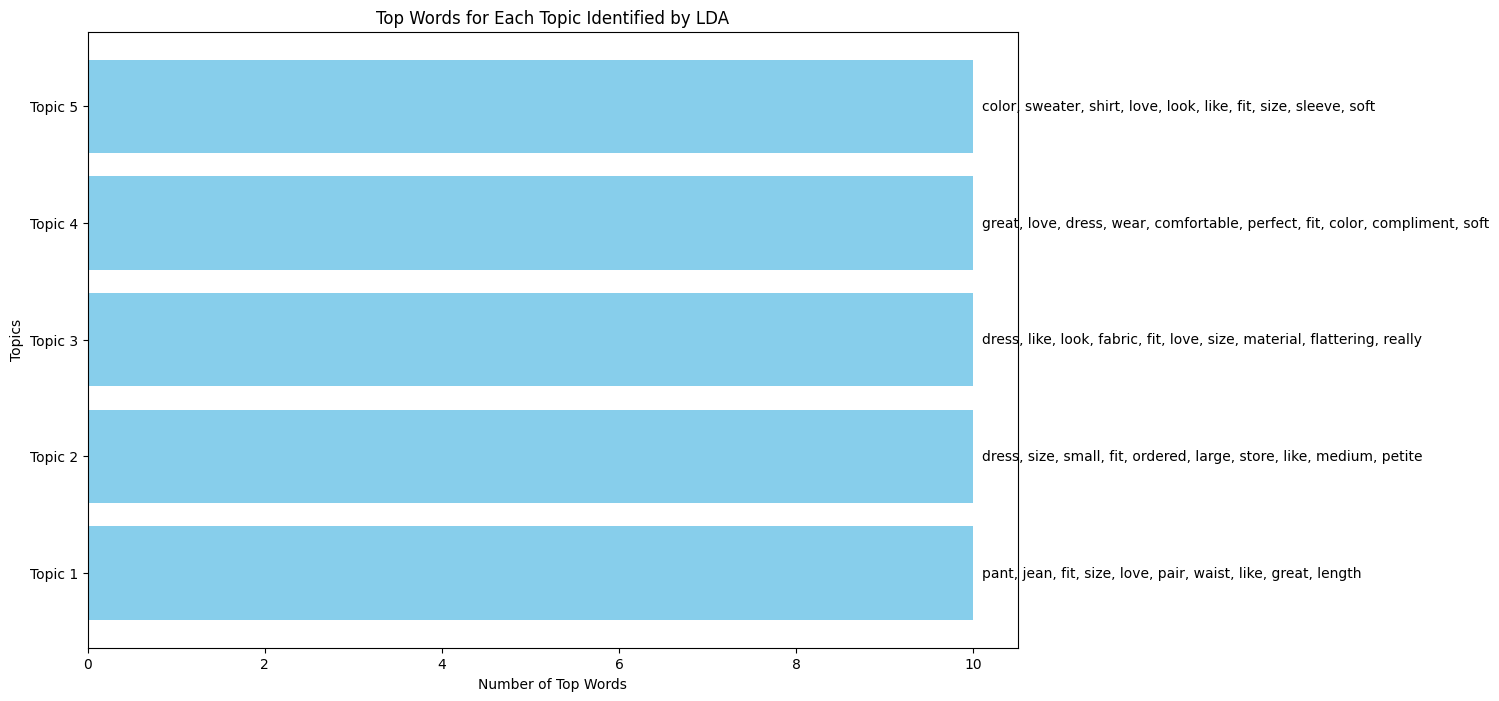

In [ ]:
topic_words = [', '.join(words) for words in topics.values()]
topic_counts = [len(words) for words in topics.values()]  


plt.figure(figsize=(12, 8))
plt.barh(list(topics.keys()), topic_counts, color='skyblue')
plt.title("Top Words for Each Topic Identified by LDA")
plt.xlabel("Number of Top Words")
plt.ylabel("Topics")


for i, words in enumerate(topic_words):
    plt.text(topic_counts[i] + 0.1, i, words, va='center', fontsize=10, color='black')

plt.show()

1. Setiap topik memiliki kata-kata kunci yang berbeda, menunjukkan bahwa LDA berhasil mengidentifikasi tema yang distingtif pada setiap topik.

2. Kata "size" muncul di hampir semua topik (1, 2, 4, dan 5), mengindikasikan bahwa ukuran merupakan aspek penting yang sering dibahas terkait produk fashion.

3. Topik 1 berfokus pada jenis pakaian seperti celana (pant, jean), ukuran (size), dan preferensi (love, like).

4. Topik 2 membahas variasi ukuran (size, small, large) dan tempat membeli (store, ordered).

5. Topik 3 menyoroti aspek tampilan dan bahan pakaian, seperti dress, look, fabric, material.

6. Topik 4 mencakup kenyamanan (comfortable), kecocokan (fit), warna (color), dan pujian (compliment).

7. Topik 5 terkait jenis pakaian (sweater, shirt) serta perasaan konsumen (love, like).

8. Kata sifat seperti "great", "perfect", "soft" muncul di beberapa topik, menandakan sentimen positif terhadap produk.

9. Kata kerja "wear" hadir di topik 3 dan 4, menyiratkan pembahasan tentang pengalaman memakai produk.